# Accessing GEDI L4A variables using NASA Harmony API

[NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) allows seamless access and production of  analysis-ready Earth observation data across different DAACs, by enabling cloud-based spatial, temporal, and variable subsetting and data conversions.  The [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) is available from NASA Harmony API. 

This tutorial demonstrates how to directly access and subset the GEDI L4A variables using Harmony API for an area in [NASA's Delta-X project](https://deltax.jpl.nasa.gov/). The Delta-X project collects [field and airborne measurements](https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=41) of ecological and hydrology variables over the two river basins (Atchafalaya and Terrebonne) in the Mississippi River Delta of the United States. The subset of the GEDI L4A dataset for the Delta-X area can enable a comparison of aboveground biomass between GEDI L4A and the field measurements.

While NASA's Harmony services are available directly through RESTful API, we will use [Harmony-Py](https://github.com/nasa/harmony-py) Python library for this tutorial. Harmony-Py provides a friendly interface for integrating with NASA's Harmony Services. In addition to Harmony-Py, this tutorial requires the following Python modules installed in your system: `h5py`, `requests`, `datetime`, `pandas`, `geopandas`, `contextily`. Requirements are also in [requirements.txt](requirements.txt).


In [1]:
# import python modules
%matplotlib inline
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import BBox, Client, Collection, Environment, Request

NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can set up NASA Earthdata Login authentication using a `.netrc` file. Please refer to the instructions here: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:

```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with `auth` parameter.

In [2]:
harmony_client = Client()

Now let's retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata's unique ID for its dataset. 

In [3]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
doisearch=f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2237824918-ORNL_CLOUD'

Let's create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [4]:
collection = Collection(id=concept_id)
variables = ['/BEAM0101/agbd', 
             '/BEAM0101/l4_quality_flag', 
             '/BEAM0101/shot_number',
             '/BEAM0101/delta_time', 
             '/BEAM0101/lat_lowestmode', 
             '/BEAM0101/lon_lowestmode']
temporal_range = {'start': datetime(2019, 4, 1), 
                  'stop': datetime(2022, 12, 31)}

We will use the spatial extent of a [Pre-DeltaX Vegetation Structure dataset](https://doi.org/10.3334/ORNLDAAC/1805). The location and aboveground biomass  of the *Salix nigra* plots collected in the Spring of 2015 are provided as a GeoJSON file at `/polygons/atchafalaya_salix_spring15.json`. Let's open this file and compute its bound.

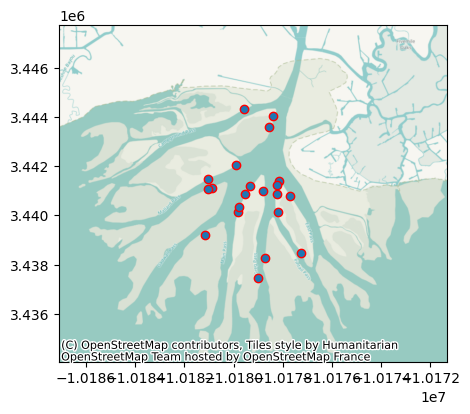

In [5]:
salix = gpd.read_file("polygons/atchafalaya_salix_spring15.json") 
b = salix.total_bounds
# bounding box for Harmony
bounding_box = BBox(w=b[0], s=b[1], e=b[2], n=b[3])
# map of Salix plots
ax=salix.to_crs(epsg=3857).plot(figsize=(5, 5), edgecolor='red')
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax, zoom = 13)

Now we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded. 

In [6]:
# Additional imports
import sys
import os
import json
from ipfs_stac import client
from pathlib import Path

# Import the easier_utils module containing helper functions
sys.path.append('scripts')
import easier_utils as eu
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import requests
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient
import datetime as dt 

polygon_features_path = Path(Path(os.getcwd()) / "polygons")
feat_path = Path(polygon_features_path / "atchafalaya_salix_spring15.json")
feat = gpd.read_file(feat_path.as_posix())
feat.geometry = feat.geometry.apply(orient, args=(1,))


doi = "10.3334/ORNLDAAC/2056"  # GEDI L4A DOI

# CMR API base url
cmrurl = "https://cmr.earthdata.nasa.gov/search/"

doisearch = cmrurl + "collections.json?doi=" + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()["feed"]["entry"][0]["id"]
concept_id
geojson = {
    "shapefile": ("atchafalaya_salix_spring15.geojson", feat.geometry.to_json(), "application/geo+json")
}

page_num = 1
page_size = 2000  # CMR page size limit
# CMR formatted start and end times
dt_format = "%Y-%m-%dT%H:%M:%SZ"

start_date=dt.datetime(2019, 4, 1)
end_date=dt.datetime(2022, 12, 31)
temporal_str = start_date.strftime(dt_format) + "," + end_date.strftime(dt_format)

page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "simplify-shapefile": "true",  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + "granules.json"
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()["feed"]["entry"]

    if granules:
        for g in granules:
            granule_url = ""
            granule_poly = ""

            # read file size
            granule_size = float(g["granule_size"])

            # reading bounding geometries
            if "polygons" in g:
                polygons = g["polygons"]
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    ltln = list(map(" ".join, zip(i, i)))
                    multipolygons.append(
                        Polygon(
                            [
                                [float(p.split(" ")[1]), float(p.split(" ")[0])]
                                for p in ltln
                            ]
                        )
                    )
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g["links"]:
                if (
                    "title" in links
                    and links["title"].startswith("Download")
                    and links["title"].endswith(".h5")
                ):
                    granule_url = links["href"]
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break


# # adding bound as the last row into the dataframe
# # we will use this later in the plot
# granule_arr.append(["amapa", 0, amapa.geometry.item()])

# creating a pandas dataframe
l4adf = pd.DataFrame(
    granule_arr, columns=["granule_url", "granule_size", "granule_poly"]
)

# Drop granules with empty geometry
l4adf = l4adf[l4adf["granule_poly"] != ""]

print("Total granules found: ", len(l4adf.index) - 1)
print("Total file size (MB): ", l4adf["granule_size"].sum())


In [7]:
# Setting the properties to connect to the Easier STAC Endpoint and the local IPFS gateway address.
# See `Getting Started` for more information.
config = eu.import_configuration()
ipfs_gateway_ip = config["ipfs_gateway_ip"]
ipfs_gateway_port = config["ipfs_gateway_port"]
stac_collection_endpoint = config["stac_endpoint"]

# Creating our client object with the properties set above
easier_client2 = client.Web3(
    stac_endpoint=stac_collection_endpoint,
    local_gateway=ipfs_gateway_ip,
    gateway_port=ipfs_gateway_port,
)

# Get path to the amapa.json file
# salix = gpd.read_file("polygons/atchafalaya_salix_spring15.json") 
# polygon_features_path = Path(Path(os.getcwd()), "polygons", "amapa.json").as_posix()
collection_name = "GEDI_L4A_AGB_Density_V2_1_2056.v2.1"
polygon_features_path = Path(Path(os.getcwd()), "polygons", "atchafalaya_salix_spring15.json").as_posix()
feat = json.load(open(polygon_features_path))

start_date=dt.datetime(2019, 4, 1)
end_date=dt.datetime(2022, 12, 31)

granule_results = easier_client2.searchSTAC(
    # bbox=bound,
    collections=collection_name,
    datetime=[start_date, end_date],
    bbox=salix.total_bounds
)

print(f"Total granules found from our search: {len(granule_results)}\n")
eu.print_granule_properties(granule_results[0])

# Select the asset key that contains the data we are interested in
selected_asset_key = [
    key for key in granule_results[0].assets.keys() if "gov/protected" in key
][0]

# Print the selected asset key
granule_results[0].assets[f"{selected_asset_key}"]

NameError: name 'dt' is not defined

In [8]:
import datetime as dt
# Get path to the amapa.json file
# salix = gpd.read_file("polygons/atchafalaya_salix_spring15.json") 
# polygon_features_path = Path(Path(os.getcwd()), "polygons", "amapa.json").as_posix()
collection_name = "GEDI_L4A_AGB_Density_V2_1_2056.v2.1"
polygon_features_path = Path(Path(os.getcwd()), "polygons", "atchafalaya_salix_spring15.json").as_posix()
feat = json.load(open(polygon_features_path))

start_date=dt.datetime(2019, 4, 1)
end_date=dt.datetime(2022, 12, 31)

granule_results = easier_client2.searchSTAC(
    # bbox=bound,
    collections=collection_name,
    datetime=[start_date, end_date],
    bbox=salix.total_bounds
)

print(f"Total granules found from our search: {len(granule_results)}\n")
eu.print_granule_properties(granule_results[0])

# Select the asset key that contains the data we are interested in
selected_asset_key = [
    key for key in granule_results[0].assets.keys() if "gov/protected" in key
][0]

# Print the selected asset key
granule_results[0].assets[f"{selected_asset_key}"]

Total granules found from our search: 8

Property Name     Type             Value
----------------------------------------------------------------------------------------------------------------------
type              <class 'str'>    Feature
stac_version      <class 'str'>    1.0.0
stac_extensions   <class 'list'>   
id                <class 'str'>    GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2022331191527_O22424_02_T00337_02_003_01_V002.h5
geometry          <class 'dict'>   
bbox              <class 'list'>   
properties        <class 'dict'>   
links             <class 'list'>   
assets            <class 'dict'>   
collection        <class 'str'>    GEDI_L4A_AGB_Density_V2_1_2056.v2.1
----------------------------------------------------------------------------------------------------------------------


For our purpose, we want to take a look at the `assets` property of the granule. Each item in `assets` contains 
additional properties like the file name, type and what locations the data 

<Asset href=https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2022331191527_O22424_02_T00337_02_003_01_V002.h5>

In [10]:
granule_results

[<Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2022331191527_O22424_02_T00337_02_003_01_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2022083212440_O18579_02_T03183_02_003_01_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2021308125851_O16403_03_T07197_02_002_02_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020298094127_O10573_02_T07452_02_002_02_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020126054750_O07904_02_T00337_02_002_02_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020102150820_O07538_02_T04606_02_002_02_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2019200010439_O03388_02_T00337_02_002_02_V002.h5>,
 <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2019148212155_O02594_02_T04606_02_002_02_V002.h5>]

In [9]:
from io import BytesIO
with h5py.File(BytesIO(easier_client2.getFromCID("bafybeiepdoknrjvo7kzskgehnrft6yvdzsdkrabwzx2kkajb3tdtin6gza")), "r") as hf:
        metadata = hf["METADATA/DatasetIdentification"]
        # store attributes and descriptions in an array
        data = []
        for attr in metadata.attrs.keys():
            data.append([attr, metadata.attrs[attr]])

KeyboardInterrupt: 

In [12]:
eu.print_granule_metadata(easier_client2, "bafybeiepdoknrjvo7kzskgehnrft6yvdzsdkrabwzx2kkajb3tdtin6gza")

✅  Fetching bafybeiepdoknrjvo7kzskgehnrft6yvdzsdkrabwzx2kkajb3tdtin6gza - 316562343/316562343 bytes


Table 1. Attributes and discription from `METADATA` group


attribute,description
PGEVersion,003
VersionID,01
abstract,The GEDI L4A standard data product contains predictions of aboveground biomass density within each laser footprint.
characterSet,utf8
creationDate,2022-07-26T20:44:31.778955Z
credit,"The software that generates the L4A product was implemented at the Department of Geographical Sciences at the University of Maryland (UMD), in collaboration with the GEDI Science Data Processing System at the NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland and the Institute at Brown for Environment and Society at Brown University."
fileName,GEDI04_A_2022083212440_O18579_02_T03183_02_003_01_V002.h5
gedi_l4a_githash,8145a32755ee6f4f58a2315ee244450f846d33d9
language,eng
originatorOrganizationName,GSFC GEDI-SDPS > GEDI Science Data Processing System and University of Maryland


In [13]:
variables

['/BEAM0101/agbd',
 '/BEAM0101/l4_quality_flag',
 '/BEAM0101/shot_number',
 '/BEAM0101/delta_time',
 '/BEAM0101/lat_lowestmode',
 '/BEAM0101/lon_lowestmode']

In [74]:
type(v.id)

h5py.h5g.GroupID

In [69]:
import inspect

def inspect_object_properties(obj):
    properties = {}
    for attribute_name in dir(obj):
        # Optionally skip magic methods and attributes
        if attribute_name.startswith('__') and attribute_name.endswith('__'):
            continue
        try:
            attribute_value = getattr(obj, attribute_name)
            attribute_type = type(attribute_value)
            properties[attribute_name] = (attribute_type, attribute_value)
        except AttributeError:
            continue  # In case the attribute is not accessible
    return properties

# Example usage
class MyClass:
    def __init__(self):
        self.name = "Example"
        self.value = 42

my_object = MyClass()
properties = inspect_object_properties(my_object)
for prop, (prop_type, prop_value) in properties.items():
    print(f"{prop}: {prop_type}, Value: {prop_value}")

inspect_object_properties(v)

name: <class 'str'>, Value: Example
value: <class 'int'>, Value: 42


{'_MutableMapping__marker': (object, <object at 0x1ffc8de4160>),
 '_abc_impl': (_abc._abc_data, <_abc._abc_data at 0x1fffecd0500>),
 '_d': (method,
  <bound method CommonStateObject._d of <HDF5 group "/BEAM0101/agbd_prediction" (113 members)>>),
 '_e': (method,
  <bound method CommonStateObject._e of <HDF5 group "/BEAM0101/agbd_prediction" (113 members)>>),
 '_gcpl_crt_order': (h5py.h5p.PropGCID, <h5py.h5p.PropGCID at 0x1fffda75940>),
 '_id': (h5py.h5g.GroupID, <h5py.h5g.GroupID at 0x1ffc2c4f970>),
 '_ipython_key_completions_': (method,
  <bound method MappingHDF5._ipython_key_completions_ of <HDF5 group "/BEAM0101/agbd_prediction" (113 members)>>),
 '_lapl': (NoneType, None),
 '_lcpl': (h5py.h5p.PropLCID, <h5py.h5p.PropLCID at 0x1fffec7c400>),
 'attrs': (h5py._hl.attrs.AttributeManager,
  <Attributes of HDF5 object at 2197995977072>),
 'build_virtual_dataset': (method,
  <bound method Group.build_virtual_dataset of <HDF5 group "/BEAM0101/agbd_prediction" (113 members)>>),
 'clear': (m

In [101]:
import sys
from pympler import asizeof
def as_mb(obj_size_in_bytes):
    total_size = obj_size_in_bytes/(1024 **2)
    return f"{total_size:.3f}"
    
print(f"col_names: {as_mb(asizeof.asizeof(col_names))} mb")
print(f"col_val: {as_mb(asizeof.asizeof(col_val))} mb")
print(f"col_val: {as_mb(asizeof.asizeof(beam))} mb")
print(f"col_val: {as_mb(asizeof.asizeof(hf_in))} mb")

col_names: 0.002 mb
col_val: 129.173 mb
col_val: 0.000 mb
col_val: 0.000 mb


In [87]:
print(subfile)
col_names = []
col_val = []
for k, v in beam.items():
    if type(v.id) == h5py.h5d.DatasetID: 
        print(f"{k} | {v.id} | {type(v.id)}")
        col_names.append(k)
        col_val.append(v[:].tolist())

C:\github\client_projects\umd\gedi_tutorials\tmp\GEDI04_A_2021308125851_O16403_03_T07197_02_002_02_V002.h5
agbd | <h5py.h5d.DatasetID object at 0x000001FFC4DDD030> | <class 'h5py.h5d.DatasetID'>
agbd_pi_lower | <h5py.h5d.DatasetID object at 0x000001FFC4DDE160> | <class 'h5py.h5d.DatasetID'>
agbd_pi_upper | <h5py.h5d.DatasetID object at 0x000001FFC4DDDE40> | <class 'h5py.h5d.DatasetID'>
agbd_se | <h5py.h5d.DatasetID object at 0x000001FFC4DDF380> | <class 'h5py.h5d.DatasetID'>
agbd_t | <h5py.h5d.DatasetID object at 0x000001FFC4DDD170> | <class 'h5py.h5d.DatasetID'>
agbd_t_se | <h5py.h5d.DatasetID object at 0x000001FFC4DDE250> | <class 'h5py.h5d.DatasetID'>
algorithm_run_flag | <h5py.h5d.DatasetID object at 0x000001FFC4DDDE40> | <class 'h5py.h5d.DatasetID'>
beam | <h5py.h5d.DatasetID object at 0x000001FFC4DDD3A0> | <class 'h5py.h5d.DatasetID'>
channel | <h5py.h5d.DatasetID object at 0x000001FFC4DDF010> | <class 'h5py.h5d.DatasetID'>
degrade_flag | <h5py.h5d.DatasetID object at 0x000001FFC

In [91]:
!pip install pympler

   ---------------------------------------- 0.0/165.8 kB ? eta -:--:--
   ---- ---------------------------------- 20.5/165.8 kB 640.0 kB/s eta 0:00:01
   -------------- ------------------------ 61.4/165.8 kB 825.8 kB/s eta 0:00:01
   ---------------------------------------- 165.8/165.8 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [109]:
subset_df = pd.DataFrame()

def as_mb(obj_size_in_bytes):
    total_size = obj_size_in_bytes/(1024 **2)
    return f"{total_size:.3f}"


for subfile in glob(r'C:\github\client_projects\umd\gedi_tutorials\tmp\*.h5'):
    hf_in = h5py.File(subfile, 'r')
    print(subfile)
    beam = hf_in['BEAM0101']
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        if type(value.id) == h5py.h5d.DatasetID: 
            col_names.append(key)
            col_val.append(value[:].tolist())

    # Appending to the subset_df dataframe
    beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
    subset_df = pd.concat([subset_df, beam_df])
    
    print(f"col_names: {as_mb(asizeof.asizeof(col_names))} mb")
    print(f"col_val: {as_mb(asizeof.asizeof(col_val))} mb")
    print(f"col_val: {as_mb(asizeof.asizeof(beam_df))} mb")
    print(f"col_val: {as_mb(asizeof.asizeof(subset_df))} mb")
    
    hf_in.close()
# print head of dataframe
subset_df.head()
    

C:\github\client_projects\umd\gedi_tutorials\tmp\GEDI04_A_2021308125851_O16403_03_T07197_02_002_02_V002.h5
col_names: 0.002 mb
col_val: 129.650 mb
col_val: 113.807 mb
col_val: 113.807 mb
C:\github\client_projects\umd\gedi_tutorials\tmp\GEDI04_A_2022331191527_O22424_02_T00337_02_003_01_V002.h5
col_names: 0.002 mb
col_val: 129.173 mb
col_val: 114.971 mb
col_val: 309.148 mb


,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,agbd_t,agbd_t_se,algorithm_run_flag,beam,channel,degrade_flag,...,predictor_limit_flag,response_limit_flag,selected_algorithm,selected_mode,selected_mode_flag,sensitivity,shot_number,solar_elevation,surface_flag,xvar
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,5,2,30,...,255,255,1,0,0,4.501169,164030500300068006,-32.350292,1,"[-9999.0, -9999.0, -9999.0, -9999.0]"
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,5,2,30,...,255,255,1,0,0,-3.878864,164030500300068007,-32.349781,1,"[-9999.0, -9999.0, -9999.0, -9999.0]"
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,5,2,30,...,255,255,1,0,0,10.391713,164030500300068008,-32.349270,1,"[-9999.0, -9999.0, -9999.0, -9999.0]"
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,5,2,30,...,255,255,1,0,0,0.815548,164030500300068009,-32.347778,0,"[-9999.0, -9999.0, -9999.0, -9999.0]"
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,5,2,30,...,255,255,1,0,0,0.840205,164030500300068010,-32.347240,0,"[-9999.0, -9999.0, -9999.0, -9999.0]"


In [105]:
subset_df = pd.DataFrame()
for subfile in glob('*_subsetted.h5'):
    hf_in = h5py.File(subfile, 'r')
    beam = hf_in['BEAM0101']
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        col_names.append(key)
        col_val.append(value[:].tolist())

    # Appending to the subset_df dataframe
    beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
    subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

,agbd,delta_time,l4_quality_flag,lat_lowestmode,lon_lowestmode,shot_number
0,10.799248,4.431568e+07,0,29.518527,-91.458764,25940500200065178
1,10.651052,4.431568e+07,0,29.518904,-91.458361,25940500200065179
2,10.651052,4.431568e+07,0,29.519282,-91.457958,25940500200065180
3,10.815543,4.431568e+07,0,29.519659,-91.457556,25940500200065181
4,10.634878,4.431568e+07,0,29.520036,-91.457153,25940500200065182


In [ ]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  spatial=bounding_box,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')
harmony_client.status(subset_job_id)

# print(f'Waiting for the job to finish')
# results = harmony_client.result_json(subset_job_id, show_progress=True)

In [ ]:
print(f'Downloading subset files...')
futures = harmony_client.download_all("748e4bd7-5b2c-48b9-b576-def81bf774e5", overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

In [ ]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  spatial=bounding_box,
                  ignore_errors=True)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

All the subsetted files are saved as `_subsetted.h5`. Let's open these `h5` files and plot the `agbd` value in a map.

In [ ]:
subset_df = pd.DataFrame()
for subfile in glob('*_subsetted.h5'):
    hf_in = h5py.File(subfile, 'r')
    beam = hf_in['BEAM0101']
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        col_names.append(key)
        col_val.append(value[:].tolist())

    # Appending to the subset_df dataframe
    beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
    subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

In [ ]:
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax1=gdf_epsg3857.plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(7, 5))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax1, column='agbd', alpha=0.1, linewidth=0, legend=True)
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax1, zoom=13)

Now that we have GEDI data downloaded, can you compare the aboveground estimates of GEDI L4A with that of the [Pre-DeltaX vegetation dataset](https://doi.org/10.3334/ORNLDAAC/1805)?

In the above steps, we used the Harmony services and retrieved the subsetted data directly to the local environment for further analysis without using the AWS cloud. The Harmony subsets data can also be directly accessed from the AWS `us-west-2` region if that is a preference.